# Local alignment and HIV drug resistance

TO DO: Insert either info on patients selected (metadata), and a means to auto download it

### Running LAST Alignment 

In [ ]:
!lastdb -P8 -uNEAR hxb2db HXB2_reference.fasta

In [ ]:
!last-train -P8 -Q0 hxb2db SRR4089868.fastq > SRR4089868.train

In [ ]:
!lastal -P8 --split -p SRR4089868.train hxb2db SRR4089868.fastq > out_SRR4089868.maf


### Analyze Results

In [1]:
from Bio import SeqIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Bio.Seq import Seq

Why are we only looking at pol region?

"Note that reverse transcription is a key part of the life cycle. Reverse transcription is carried out by an enzyme called reverse transcriptase, which is encoded in the HIV genome (segment labeled RT in the the pol region in the figure below of the structure of an HIV genome)."



In [5]:
gb_file = "K03455.1.gb"
gb_record = SeqIO.read(gb_file, "genbank")

Biopython automatically converts to 0-based, Python-style indexing internally. So pol in GenBank is 2358..5096

In [6]:
# store whole genome sequence
genome_seq = gb_record.seq

In [7]:
# Loop through CDS features to find pol polyprotein
for feature in gb_record.features:
    if feature.type == "CDS":
        gene_name = feature.qualifiers.get("note", [""])[0]
        if "pol polyprotein" in gene_name:
            pol_sequence = feature.location.extract(gb_record.seq)
            # coordinates
            pol_start = feature.location.start
            pol_end = feature.location.end
            # translation (there is a translation in the GenBank file)
            pol_translation = feature.qualifiers.get("translation", [""])[0]
            print("pol coordinates:", pol_start, pol_end)
            print("pol sequence length:", len(pol_sequence))
            print("pol sequence:", pol_sequence)
            print("pol translation length:", len(pol_translation))
            print("pol translation:", pol_translation)
            break

pol coordinates: 2357 5096
pol sequence length: 2739
pol sequence: ATGAGTTTGCCAGGAAGATGGAAACCAAAAATGATAGGGGGAATTGGAGGTTTTATCAAAGTAAGACAGTATGATCAGATACTCATAGAAATCTGTGGACATAAAGCTATAGGTACAGTATTAGTAGGACCTACACCTGTCAACATAATTGGAAGAAATCTGTTGACTCAGATTGGTTGCACTTTAAATTTTCCCATTAGCCCTATTGAGACTGTACCAGTAAAATTAAAGCCAGGAATGGATGGCCCAAAAGTTAAACAATGGCCATTGACAGAAGAAAAAATAAAAGCATTAGTAGAAATTTGTACAGAGATGGAAAAGGAAGGGAAAATTTCAAAAATTGGGCCTGAAAATCCATACAATACTCCAGTATTTGCCATAAAGAAAAAAGACAGTACTAAATGGAGAAAATTAGTAGATTTCAGAGAACTTAATAAGAGAACTCAAGACTTCTGGGAAGTTCAATTAGGAATACCACATCCCGCAGGGTTAAAAAAGAAAAAATCAGTAACAGTACTGGATGTGGGTGATGCATATTTTTCAGTTCCCTTAGATGAAGACTTCAGGAAGTATACTGCATTTACCATACCTAGTATAAACAATGAGACACCAGGGATTAGATATCAGTACAATGTGCTTCCACAGGGATGGAAAGGATCACCAGCAATATTCCAAAGTAGCATGACAAAAATCTTAGAGCCTTTTAGAAAACAAAATCCAGACATAGTTATCTATCAATACATGGATGATTTGTATGTAGGATCTGACTTAGAAATAGGGCAGCATAGAACAAAAATAGAGGAGCTGAGACAACATCTGTTGAGGTGGGGACTTACCACACCAGACAAAAAACATCAGAAAGAACCTCCATTCCTTTGGATGGGTTATGAACTCCATCCTGATAAATGGACAGTACAGCCTATAGTGCTGCCA

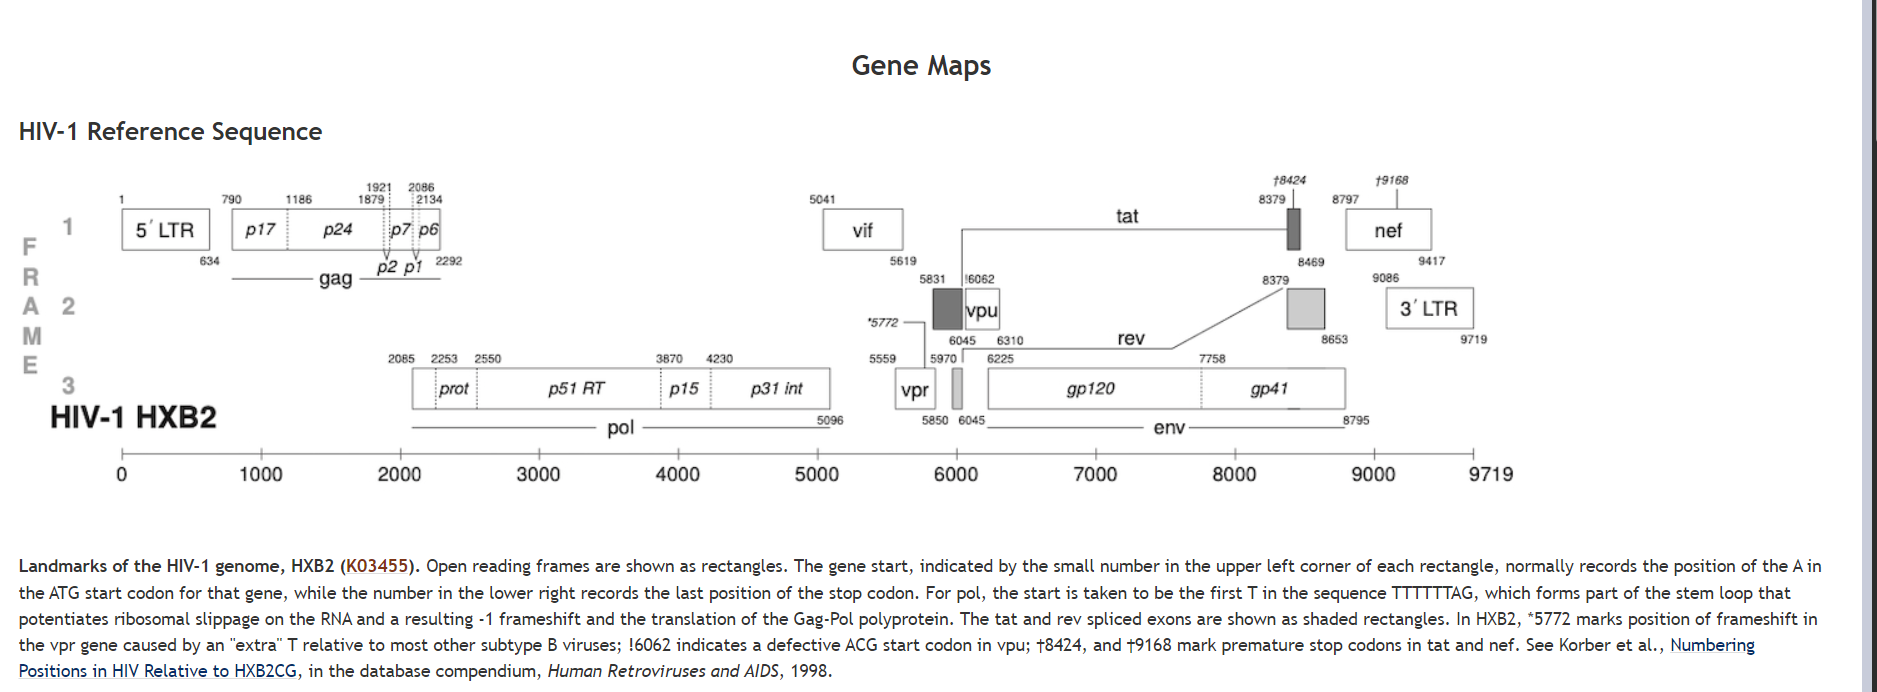

Reverse Transcriptase in the HIV HXB2 Reference Genome starts at 2550 and ends at 3870. https://www.hiv.lanl.gov/content/sequence/HIV/MAP/landmark.html

In [8]:
start_rt = 2549
end_rt = 3870

In [9]:
def get_rt_index (index, start_rt):
    return start_rt + (index -1) * 3

Sanity Check: Do all key positions in the HIV reference genome correspond to the wild type, e.g. 41-M, 65-K? Yes

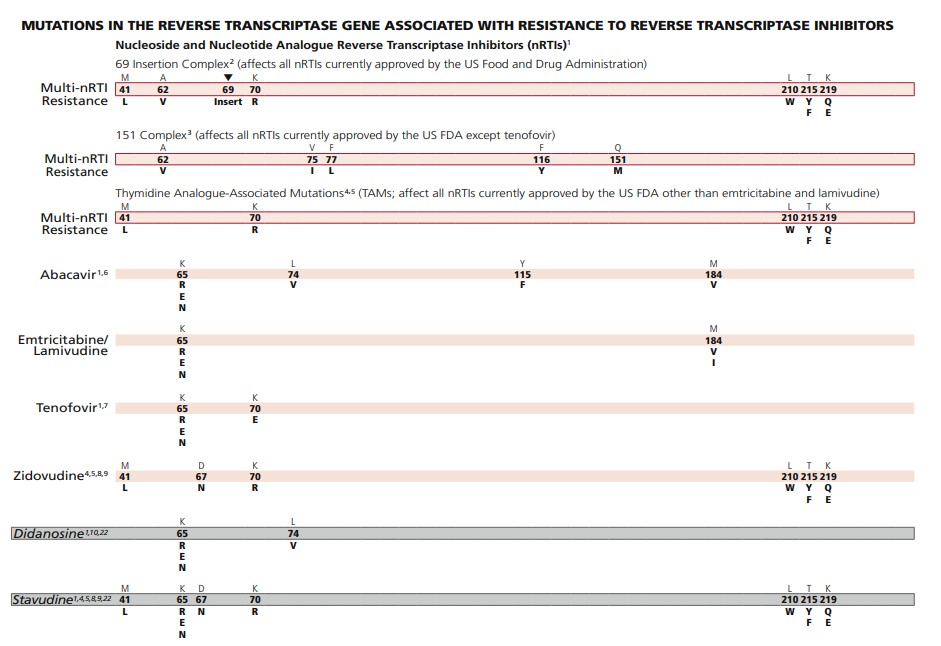

2462 +250 = 2710

2549 + (40 *3 ) = 2669:2672

In [10]:
key_positions = [41, 65, 67, 70, 210, 215, 219]
for pos in key_positions:
    pos_index = get_rt_index(pos, start_rt)
    print(f"Position {pos} in RT corresponds to genome index {pos_index}")
    codon_start = pos_index
    codon_end = codon_start + 3
    rt_codon_sequence = genome_seq[codon_start:codon_end]
    rt_protein_sequence = rt_codon_sequence.translate()
    print(f"RT codon sequence at position {pos}:", rt_codon_sequence)
    print(f"RT protein sequence at position {pos}:", rt_protein_sequence)

Position 41 in RT corresponds to genome index 2669
RT codon sequence at position 41: ATG
RT protein sequence at position 41: M
Position 65 in RT corresponds to genome index 2741
RT codon sequence at position 65: AAA
RT protein sequence at position 65: K
Position 67 in RT corresponds to genome index 2747
RT codon sequence at position 67: GAC
RT protein sequence at position 67: D
Position 70 in RT corresponds to genome index 2756
RT codon sequence at position 70: AAA
RT protein sequence at position 70: K
Position 210 in RT corresponds to genome index 3176
RT codon sequence at position 210: TTG
RT protein sequence at position 210: L
Position 215 in RT corresponds to genome index 3191
RT codon sequence at position 215: ACC
RT protein sequence at position 215: T
Position 219 in RT corresponds to genome index 3203
RT codon sequence at position 219: AAA
RT protein sequence at position 219: K


Parse MAF Alignment File
- Contain both aligned reference and patient sequence data

In [11]:
def parse_maf(file_path):
    extracted_data = [] 
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    i = 0
    while i < len(lines):
        line = lines[i].strip()

        if line.startswith("a"):
            # get score
            score = line.split("score=")[1].split()[0]
        
        if line.startswith("s"):
            ref_sequence= line.split()[6]
            ref_orientation = line.split()[4]
            ref_header = line.split()[1]
            ref_start = int(line.split()[2])
            length = int(line.split()[3])
        
            if i + 1 < len(lines):
                aligned_line = lines[i + 1].strip()
                if aligned_line.startswith("s"):
                    aligned_header = aligned_line.split()[1] 
                    aligned_dna = aligned_line.split()[6] 
                    dna_orientation = aligned_line.split()[4]
                    dna_start = int(aligned_line.split()[2])
                    
                    extracted_data.append((score, ref_header, ref_sequence, ref_orientation, ref_start, length, aligned_header, aligned_dna, dna_orientation, dna_start))
            
        i += 1
    
    return extracted_data


In [12]:
alignments = parse_maf("out_SRR4089868.maf")

In [13]:
df_alignments = pd.DataFrame(alignments, columns=["score", "ref_header", "ref_sequence", "ref_orientation", "ref_start", "length", "aligned_header", "aligned_dna", "dna_orientation", "dna_start"])

In [14]:
df_alignments

,score,ref_header,ref_sequence,ref_orientation,ref_start,length,aligned_header,aligned_dna,dna_orientation,dna_start
0,618,K03455.1,AGTCAGATTTACCCAGGGATTAAAGTAAGGCAATTATGTAAACTCC...,+,3350,131,SRR4089868.3,AGTCAGATTTACTCAGGGATTAAAGTAAGGCAATTATGTAAACTCC...,-,0
1,619,K03455.1,AGTCAGATTTACCCAGGGATTAAAGTAAGGCAATTATGTAAACTCC...,+,3350,131,SRR4089868.3,AGTCAGATTTACTCAGGGATTAAAGTAAGGCAATTATGTAAACTCC...,+,0
2,708,K03455.1,ACCATACCTAGTATAAACAATGAGACACCAGGGATTAGATATCAGT...,+,2939,140,SRR4089868.8,ACCATACCTAGTATAAACAATGAAACACCAGGGATTAGATATCAAT...,-,1
3,710,K03455.1,ACCATACCTAGTATAAACAATGAGACACCAGGGATTAGATATCAGT...,+,2939,140,SRR4089868.8,ACCATACCTAGTATAAACAATGAAACACCAGGGATTAGATATCAAT...,+,1
4,657,K03455.1,ATTCCAAAGTAGCATGACAAAAATCTTAGAGCCTTTTAGAAAACAA...,+,3025,149,SRR4089868.1,ATTCCAAAGTAGCATGACAAAAATCTTATAGCCTTTTAGAAAAGGA...,+,0
...,...,...,...,...,...,...,...,...,...,...
196930,1220,K03455.1,AAATAGGGCAGCATAGAACAAAAATAGAGGAGCTGAGACAACATCT...,+,3129,250,SRR4089868.97506,AAATAGGGCATCATAGAACAAAAATAGAGGAACTGAGACAACATCT...,-,0
196931,847,K03455.1,GCATTTACCATACCTAGTATAAACAATGAGACACCAGGGATTAGAT...,+,2933,181,SRR4089868.97509,GCATTCACCATACCTAGTATAAACAGTGAGACACCAGGGATTAGAT...,-,0
196932,848,K03455.1,GCATTTACCATACCTAGTATAAACAATGAGACACCAGGGATTAGAT...,+,2933,181,SRR4089868.97509,GCATTCACCATACCTAGTATAAACAGTGAGACACCAGGGATTAGAT...,+,0
196933,1207,K03455.1,TTTGGATGGGTTATGAACTCCATCCTGATAAATGGACAGTACAGCC...,+,3231,250,SRR4089868.97510,TTTGGATGGGTTATGAACTCCATCCCGATAAATGGACAGTACAGCC...,-,0


For multiple alignments of the same read, got the alignment with the  best score for each read

In [15]:
# get the ones wit the same aligned_header, dont do anything
df_alignments = df_alignments.sort_values('score', ascending=False).drop_duplicates('aligned_header', keep='first')

In [16]:
df_alignments.describe()

,ref_start,length,dna_start
count,97469.000000,97469.000000,97469.000000
mean,2719.912618,224.524628,1.315916
std,377.784579,43.478156,9.186444
min,2008.000000,20.000000,0.000000
25%,2345.000000,216.000000,0.000000
50%,2784.000000,248.000000,0.000000
75%,3043.000000,251.000000,0.000000
max,3563.000000,257.000000,230.000000


Get all alignments from range of 2550 to 3870 (but offset by 1 because of python indexing -> start at 2549)


In [17]:
df_alignments["ref_end"] = df_alignments["ref_start"] + df_alignments["length"]

df_alignments_RT = df_alignments[(df_alignments["ref_start"] >= start_rt) & (df_alignments["ref_end"] <= end_rt)]

In [18]:
df_alignments_RT.describe()

,ref_start,length,dna_start,ref_end
count,62300.000000,62300.000000,62300.000000,62300.000000
mean,2967.906565,228.376244,1.205939,3196.282809
std,203.648212,42.545440,10.108114,201.252921
min,2549.000000,21.000000,0.000000,2590.000000
25%,2801.000000,228.000000,0.000000,3035.000000
50%,2952.000000,250.000000,0.000000,3185.000000
75%,3139.000000,251.000000,0.000000,3376.000000
max,3563.000000,257.000000,230.000000,3769.000000


Total Reads: 195020

In [19]:
genetic_code = {
        'TTT': 'F', 'TTC': 'F', 'TTA': 'L', 'TTG': 'L',
        'CTT': 'L', 'CTC': 'L', 'CTA': 'L', 'CTG': 'L',
        'ATT': 'I', 'ATC': 'I', 'ATA': 'I', 'ATG': 'M',
        'GTT': 'V', 'GTC': 'V', 'GTA': 'V', 'GTG': 'V',
        'TCT': 'S', 'TCC': 'S', 'TCA': 'S', 'TCG': 'S',
        'CCT': 'P', 'CCC': 'P', 'CCA': 'P', 'CCG': 'P',
        'ACT': 'T', 'ACC': 'T', 'ACA': 'T', 'ACG': 'T',
        'GCT': 'A', 'GCC': 'A', 'GCA': 'A', 'GCG': 'A',
        'TAT': 'Y', 'TAC': 'Y', 'TAA': '*', 'TAG': '*',
        'CAT': 'H', 'CAC': 'H', 'CAA': 'Q', 'CAG': 'Q',
        'AAT': 'N', 'AAC': 'N', 'AAA': 'K', 'AAG': 'K',
        'GAT': 'D', 'GAC': 'D', 'GAA': 'E', 'GAG': 'E',
        'TGT': 'C', 'TGC': 'C', 'TGA': '*', 'TGG': 'W',
        'CGT': 'R', 'CGC': 'R', 'CGA': 'R', 'CGG': 'R',
        'AGT': 'S', 'AGC': 'S', 'AGA': 'R', 'AGG': 'R',
        'GGT': 'G', 'GGC': 'G', 'GGA': 'G', 'GGG': 'G'
    }

In [20]:
# want to see mutations from aligned_dna to ref_sequence on key positions only
def get_mutations(pos, aa_ref):
    aa_ref_not = 0
    counts_dict = {}
    codon_ref_start = get_rt_index(pos, start_rt)
    codon_ref_end = codon_ref_start + 3

    for row in df_alignments_RT.itertuples():
        if not (row.ref_start <= codon_ref_start and row.ref_end >= codon_ref_end):
            continue   
        # Offset of codon within the aligned region for patient seq
        offset = codon_ref_start - row.ref_start # 2669 2308
        codon_seq = row.aligned_dna[offset:offset + 3]
        codon_seq = codon_seq.upper()
        aa = genetic_code.get(codon_seq, 'X')
        
        # reference sequence
        codon_seq_ref = row.ref_sequence[offset:offset + 3]
        codon_seq_ref = codon_seq_ref.upper()
        aa_ref_1 = genetic_code.get(codon_seq_ref, 'X')
        if aa_ref_1 != aa_ref:
            continue
        
        counts_dict[aa] = counts_dict.get(aa, 0) + 1
   
    print("Counts of amino acids at position")
    print("Position ",  pos, ":", ", ".join(f"{aa}: {count}" for aa, count in counts_dict.items()))
    coverage = sum(counts_dict.values())
    print("Coverage at position", pos, ":", coverage)
    return counts_dict, coverage
    

In [21]:
key_positions = [41, 65, 67, 70, 210, 215, 219]
aa_ref_list = ["M", "K", "D", "K", "L", "T", "K"]
pos_mutations = {}

for i, pos in enumerate(key_positions):
    mutations, coverage = get_mutations(pos, aa_ref_list[i])
    pos_mutations[pos] = {
        "mutations": mutations,
        "coverage": coverage
    }
    print("\n")

Counts of amino acids at position
Position  41 : M: 4611, T: 33, V: 18, I: 10, L: 4, K: 6, R: 4, N: 1
Coverage at position 41 : 4687


Counts of amino acids at position
Position  65 : K: 9613, E: 36, T: 3, Q: 5, R: 43, *: 1, N: 13, X: 20, Y: 1
Coverage at position 65 : 9735


Counts of amino acids at position
Position  67 : D: 9793, E: 17, G: 66, A: 5, N: 15, Y: 7, V: 4, K: 1, X: 2, C: 1, H: 1
Coverage at position 67 : 9912


Counts of amino acids at position
Position  70 : K: 10611, T: 20, I: 4, G: 1, E: 50, Q: 9, N: 8, R: 56, *: 6, X: 13, M: 1
Coverage at position 70 : 10779


Counts of amino acids at position
Position  210 : L: 25299, M: 25, V: 22, S: 104, F: 27, W: 22, *: 17, G: 1, X: 9, C: 1, P: 2, I: 2
Coverage at position 210 : 25531


Counts of amino acids at position
Position  215 : T: 22637, N: 26, L: 1, S: 32, A: 98, P: 19, H: 1, V: 1, X: 12, Y: 2, K: 2, C: 1, I: 23
Coverage at position 215 : 22855


Counts of amino acids at position
Position  219 : K: 21952, *: 7, T: 12, N:

TO DO: TABLE, COVERAGE

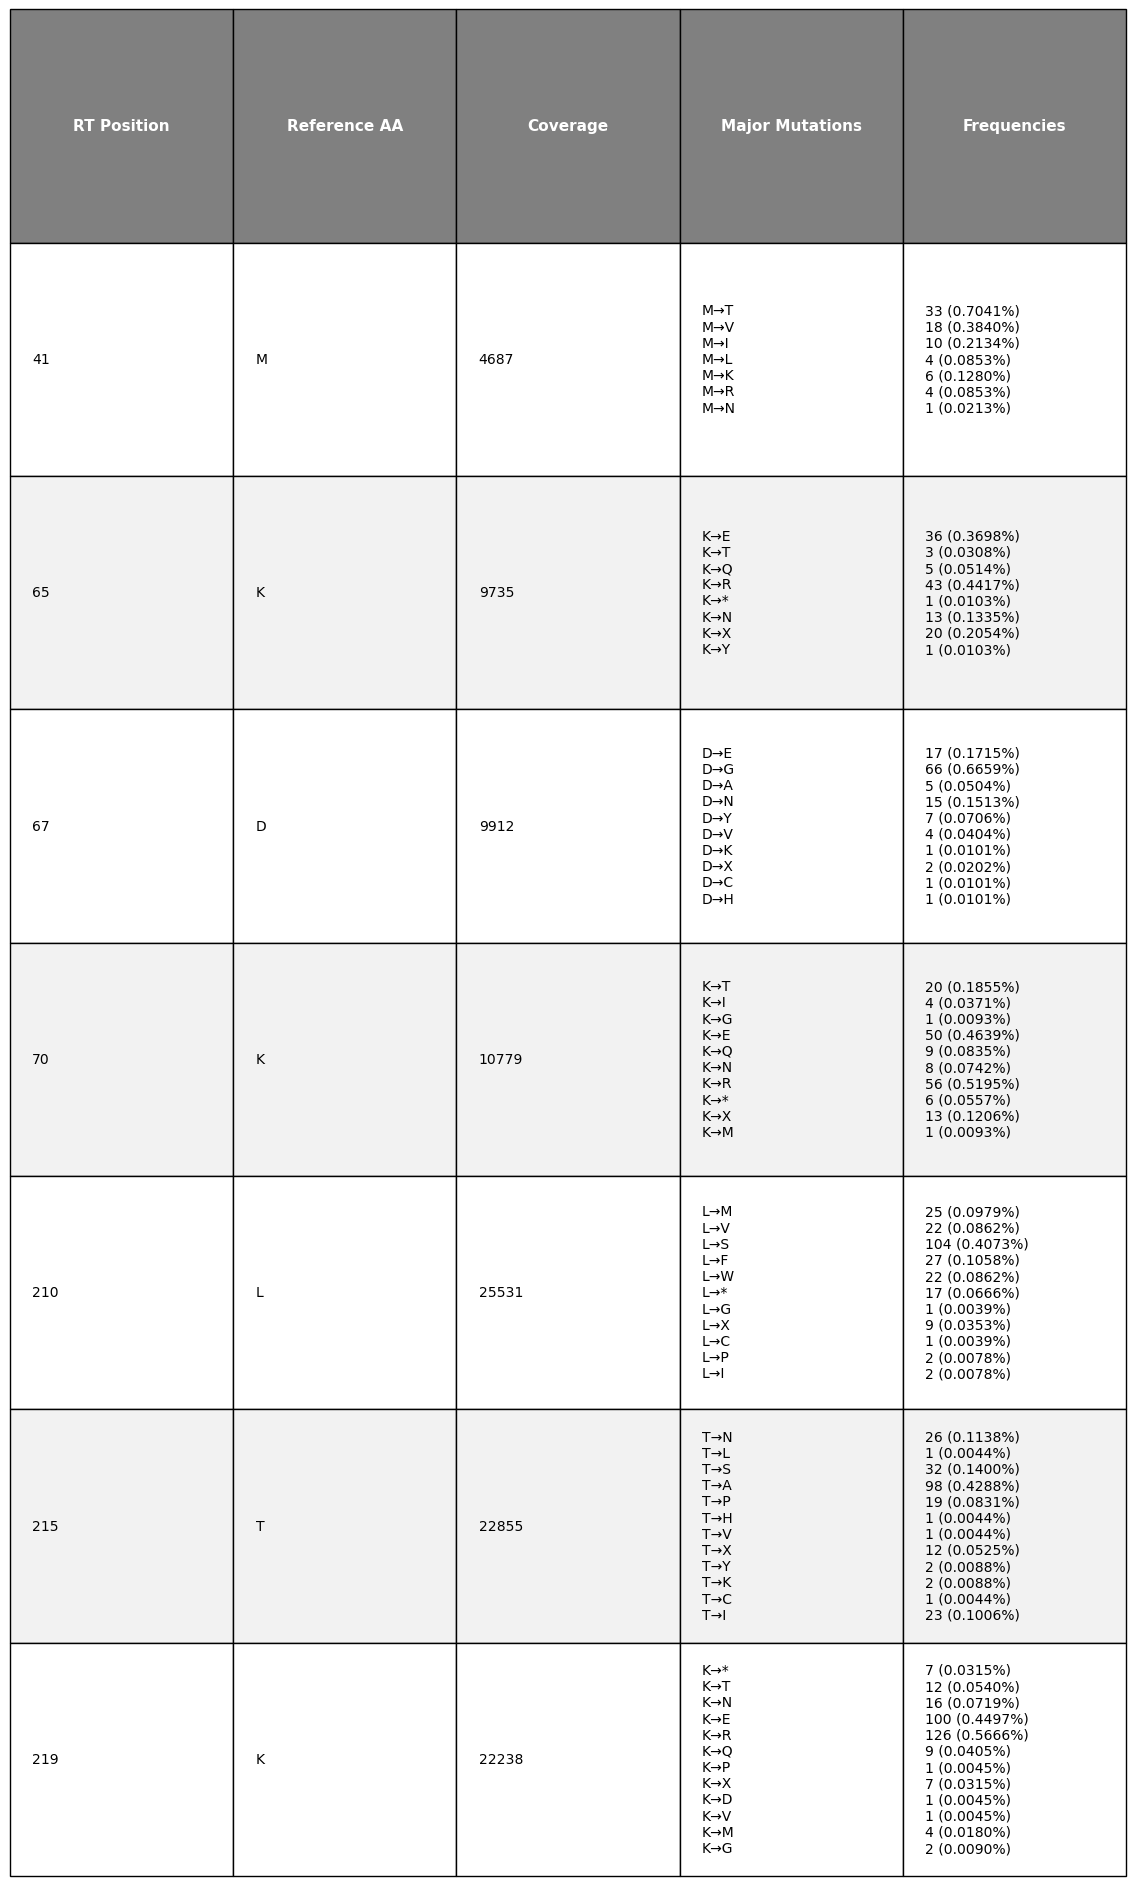

In [52]:
# Get reference AA (most common)
def get_reference_aa(muts):
    return max(muts.items(), key=lambda x: x[1])[0]

# Build rows
rows = []
for pos, info in pos_mutations.items():
    muts = info['mutations']
    cov = info['coverage']
    ref = get_reference_aa(muts)

    mut_list = []
    freq_list = []

    for aa, count in muts.items():
        if aa == ref:
            continue
        mut_list.append(f"{ref}→{aa}")
        freq_list.append(f"{count} ({count / cov * 100:.4f}%)")

    rows.append([
        str(pos),
        ref,
        str(cov),
        "\n".join(mut_list),
        "\n".join(freq_list)
    ])

# Calculate figure height
fig_height = len(rows) * 0.9

# Plot table
fig, ax = plt.subplots(figsize=(12, fig_height))
ax.axis('off')

table = ax.table(
    cellText=rows,
    colLabels=["RT Position", "Reference AA", "Coverage", "Major Mutations", "Frequencies"],
    cellLoc='left',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 14)  # Wider columns, taller rows

# Style header and alternate rows
for key, cell in table.get_celld().items():
    row, col = key
    if row == 0:
        cell.set_fontsize(11)
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor("#808080")  # Green header
    elif row % 2 == 0:
        cell.set_facecolor("#f2f2f2")  # Light gray for even rows

# Optional: save as image
plt.savefig("mutation_table.png", bbox_inches="tight", dpi=300)

# plt.tight_layout()
plt.show()